### Imports

In [2]:
import os
import pandas as pd
import hashlib
import requests
import tarfile
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random
from functools import lru_cache

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import shutil
from tensorflow.keras import regularizers

# Ativar a GPU se disponível
print("GPU disponível?" , tf.config.list_physical_devices('GPU'))

base_dir = Path(os.getcwd()).resolve().parent
base_dir

2025-06-07 00:18:50.010524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 00:18:50.026894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749255530.043719    7011 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749255530.048128    7011 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749255530.071575    7011 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPU disponível? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


PosixPath('/workspaces/APVC/APVC-ProjetoFinal')

In [3]:
def set_seed(seed=27):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(27)

In [4]:
data_dir = base_dir / 'data'
data_dir.mkdir(parents=True, exist_ok=True)
data_dir

PosixPath('/workspaces/APVC/APVC-ProjetoFinal/data')

## 1. Preparar os dados

In [5]:
import os
from collections import Counter

# Define o caminho para o diretório train
train_dir = data_dir / 'train'

# Lista para armazenar todas as classes encontradas
classes = []

# Percorre todos os arquivos em todas as subpastas
for root, dirs, files in os.walk(train_dir):
    parts = root.split('_')
    
    # Verifica se o arquivo segue o padrão esperado (pelo menos 3 partes)
    if len(parts) >= 3:
        classe = parts[-2]  # A classe é o segundo elemento
        classes.append(classe)

# Conta a ocorrência de cada classe
class_counts = Counter(classes)

# Exibe os resultados
print("Contagem de documentos por classe:")
for classe, count in class_counts.most_common():
    print(f"{classe}: {count} monumentos")

# Opcional: exibe o total de classes únicas
print(f"\nTotal de classes únicas: {len(class_counts)}")

Contagem de documentos por classe:
Igreja: 207 monumentos
Castelo: 112 monumentos
Pelourinho: 42 monumentos
Mosteiro: 37 monumentos
Ponte: 35 monumentos
Capela: 35 monumentos
Convento: 31 monumentos
Museu: 30 monumentos
Palacio: 27 monumentos
Anta: 25 monumentos
Farol: 25 monumentos
Chafariz: 24 monumentos
Praia: 22 monumentos
Forte: 22 monumentos
Cruzeiro: 21 monumentos
Casa: 20 monumentos
Torre: 19 monumentos
Castro: 15 monumentos
Jardim: 15 monumentos
Santuario: 15 monumentos
Muralhas: 10 monumentos
Aqueduto: 9 monumentos
Lagoa: 9 monumentos
Basilica: 8 monumentos
Praca: 8 monumentos
Ermida: 7 monumentos
Fonte: 7 monumentos
Padrao: 7 monumentos
Tumulo: 7 monumentos
Catedral: 6 monumentos
Dolmen: 6 monumentos
Elevador: 6 monumentos
Ruinas: 6 monumentos
Teatro: 6 monumentos
Arco: 5 monumentos
Quinta: 5 monumentos
Menir: 5 monumentos
Monumento: 5 monumentos
Cabo: 4 monumentos
Cerca: 4 monumentos
Fortaleza: 4 monumentos
Lapide: 4 monumentos
Citania: 3 monumentos
Gruta: 3 monumentos
Hosp

## 2. Primeiro Modelo - [Templos da Igreja Católica](https://www.a12.com/redacaoa12/duvidas-religiosas/qual-a-diferenca-entre-capela-igreja-catedral-basilica-e-santuario)

In [6]:
# Caminho original
train_dir = data_dir / 'train'

# Caminho destino
train_dir1 = data_dir / 'TrainModel1'
train_dir1.mkdir(exist_ok=True)

# Classes de interesse
classes_de_interesse = ['capela', 'igreja', 'catedral', 'basilica', 'santuario']

### 2.1.Criar Dataset

In [15]:
def normaliza_nome(nome):
    return nome.lower().replace('á', 'a').replace('ã', 'a').replace('ç', 'c')\
                       .replace('é', 'e').replace('í', 'i').replace('ú', 'u')

def is_valid_and_copy(file_path, dst):
    try:
        img = tf.io.read_file(file_path)
        tf.image.decode_jpeg(img, channels=3)
        shutil.copy2(file_path, dst)
    except tf.errors.InvalidArgumentError:
        print(f"Arquivo JPEG inválido ignorado: {file_path}")

def copy_valid_images(src, dst):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    
    # Pré-filtrar os ficheiros válidos
    valid_files = [
        entry.path for entry in os.scandir(src)
        if entry.is_file() and entry.name.lower().endswith(valid_extensions)
    ]
    
    # Progress bar
    with ThreadPoolExecutor(max_workers=8) as executor:
        list(tqdm(executor.map(lambda f: is_valid_and_copy(f, dst), valid_files),
                  total=len(valid_files),
                  desc=f"A copiar imagens de {src.name}"))

# ⛔ Verificar se train_dir1 já existe e está preenchido
if train_dir1.exists() and any(train_dir1.iterdir()):
    print(f"Diretório de destino já existe e não está vazio: {train_dir1}, a ignorar todo o processo.")
else:
    for root, dirs, files in os.walk(train_dir):
        root_path = Path(root)
        nome_pasta = root_path.name.lower()

        for classe in classes_de_interesse:
            if classe in nome_pasta:
                classe_normalizada = normaliza_nome(classe)
                destino_classe = train_dir1 / classe_normalizada

                destino_classe.mkdir(parents=True, exist_ok=True)
                copy_valid_images(root_path, destino_classe)
                break

A copiar imagens de Anta_Grande_da_Comenda_da_Igreja_Anta_0: 100%|██████████| 6/6 [00:00<00:00, 80.11it/s]
A copiar imagens de Antiga_Sacristia_da_Igreja_de_Santo_Antao-o-Novo_Igreja_1: 100%|██████████| 2/2 [00:00<00:00, 31.49it/s]
A copiar imagens de Antigo_Paco_Episcopal_do_Funchal_e_Capela_anexa_Capela_1: 100%|██████████| 63/63 [00:00<00:00, 179.45it/s]
A copiar imagens de Basilica_da_Estrela_Basilica_1: 100%|██████████| 20/20 [00:00<00:00, 112.40it/s]
A copiar imagens de Basilica_Da_Santissima_Trindade,_Fatima_Basilica_1: 100%|██████████| 34/34 [00:00<00:00, 209.44it/s]
A copiar imagens de Basilica_De_Nossa_Senhora_Dos_Martires,_Lisboa_Basilica_1: 100%|██████████| 5/5 [00:00<00:00, 63.69it/s]
A copiar imagens de Basilica_de_Santo_Cristo_do_Outeiro_Basilica_1: 100%|██████████| 12/12 [00:00<00:00, 100.73it/s]
A copiar imagens de Basilica_De_Sao_Pedro_Basilica_1: 100%|██████████| 5/5 [00:00<00:00, 44.58it/s]
A copiar imagens de Basilica_Do_Sagrado_Coraca_De_Jesus_Basilica_1: 100%|████

In [18]:
def is_valid_image(path):
    """Verifica se o ficheiro é uma imagem válida JPEG/PNG"""
    try:
        img = tf.io.read_file(str(path))
        tf.image.decode_jpeg(img, channels=3)
        return True
    except (tf.errors.InvalidArgumentError, tf.errors.NotFoundError):
        return False

def count_images_in_dir(class_dir, valid_extensions=('.jpg', '.jpeg', '.png')):
    """Conta imagens válidas e inválidas numa diretoria"""
    valid_count = 0
    invalid_count = 0

    image_files = [f for f in class_dir.glob('*') if f.suffix.lower() in valid_extensions]

    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(is_valid_image, image_files),
                            total=len(image_files),
                            desc=f"[{class_dir.name}] A verificar imagens"))

    for valid in results:
        if valid:
            valid_count += 1
        else:
            invalid_count += 1

    return class_dir.name, valid_count, invalid_count

def count_valid_images(directory):
    """Conta imagens válidas em todas as subpastas paralelamente"""
    print("\nContagem de imagens válidas por classe:")
    print("-----------------------------------")

    total_valid = 0
    valid_extensions = ('.jpg', '.jpeg', '.png')

    class_dirs = [d for d in sorted(directory.iterdir()) if d.is_dir()]

    results = []
    with ThreadPoolExecutor(max_workers=min(8, len(class_dirs))) as executor:
        results = list(executor.map(lambda d: count_images_in_dir(d, valid_extensions), class_dirs))

    for class_name, valid_count, invalid_count in results:
        print(f"{class_name}:")
        print(f"  - Válidas: {valid_count} imagens")
        print(f"  - Inválidas: {invalid_count} arquivos")
        total_valid += valid_count

    print("-----------------------------------")
    print(f"Total de imagens válidas: {total_valid}")
    return total_valid

total = count_valid_images(train_dir1)
total


Contagem de imagens válidas por classe:
-----------------------------------


[basilica] A verificar imagens:  17%|█▋        | 23/137 [00:00<00:02, 55.11it/s]


[basilica] A verificar imagens:  31%|███▏      | 43/137 [00:00<00:01, 81.05it/s]




[basilica] A verificar imagens:  47%|████▋     | 64/137 [00:00<00:00, 109.39it/s]









[basilica] A verificar imagens:  64%|██████▎   | 87/137 [00:01<00:00, 69.50it/s]





[basilica] A verificar imagens:  72%|███████▏  | 99/137 [00:01<00:00, 71.83it/s]




[basilica] A verificar imagens:  82%|████████▏ | 113/137 [00:01<00:00, 63.69it/s]

[basilica] A verificar imagens: 100%|██████████| 137/137 [00:01<00:00, 79.53it/s]




































































































[catedral] A verificar imagens: 100%|██████████| 431/431 [00:04<00:00, 90.80it/s]









[santuario] A verificar imagens: 100%|██████████| 397/397 [00:05<00:00, 75.71it/s]






























































































[capela] A verificar imagens: 100%|██

basilica:
  - Válidas: 137 imagens
  - Inválidas: 0 arquivos
capela:
  - Válidas: 980 imagens
  - Inválidas: 0 arquivos
catedral:
  - Válidas: 431 imagens
  - Inválidas: 0 arquivos
igreja:
  - Válidas: 4808 imagens
  - Inválidas: 0 arquivos
santuario:
  - Válidas: 397 imagens
  - Inválidas: 0 arquivos
-----------------------------------
Total de imagens válidas: 6753


6753

In [19]:
# Contagem de imagens por classe
print("Contagem de imagens por classe:")
print("-----------------------------")

total_imagens = 0

# Itera sobre cada pasta de classe
for classe_dir in sorted(train_dir1.iterdir()):
    if classe_dir.is_dir():
        # Lista apenas arquivos de imagem
        imagens = [f for f in os.listdir(classe_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        num_imagens = len(imagens)
        print(f"{classe_dir.name}: {num_imagens} imagens")
        total_imagens += num_imagens

print("-----------------------------")
print(f"Total de imagens: {total_imagens}")

Contagem de imagens por classe:
-----------------------------
basilica: 137 imagens
capela: 980 imagens
catedral: 431 imagens
igreja: 4808 imagens
santuario: 397 imagens
-----------------------------
Total de imagens: 6753


### 2.2. Data Augmentation

I0000 00:00:1749242185.136354     730 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


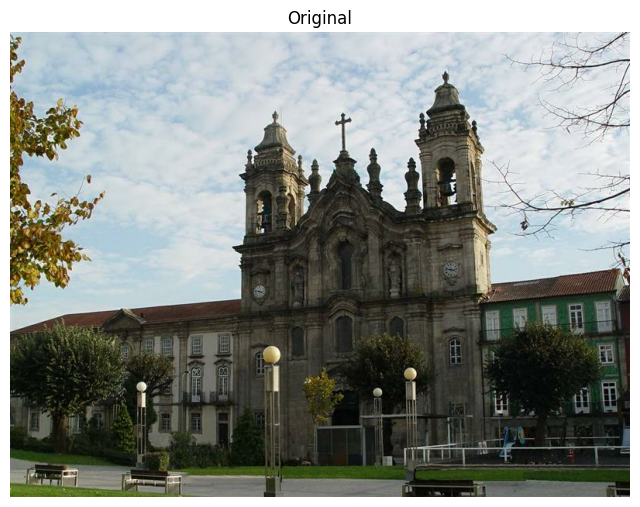

In [5]:
# Caminho para a imagem
img_path = train_dir1 / Path("basilica/035_00a72fad7bc8fe136cb099942ec29d3a.jpg")
data_dir
# Carregar a imagem
def load_image(path):
    img = tf.io.read_file(str(path))
    img = tf.image.decode_jpeg(img, channels=3)
    return img

original_image = load_image(img_path)

# Mostrar original
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title("Original")
plt.axis('off')
plt.show()

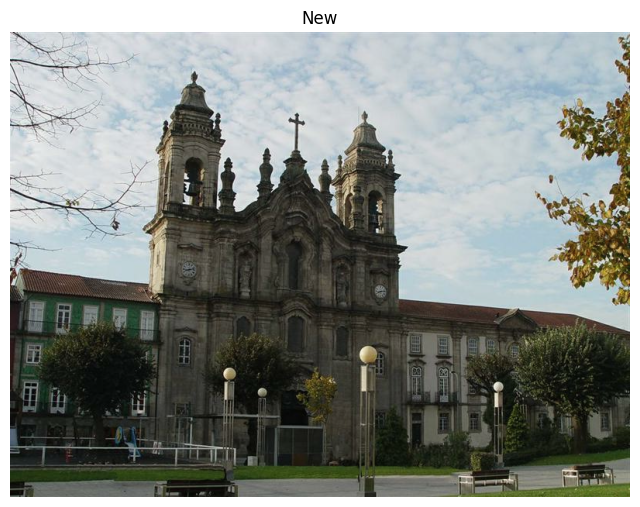

In [6]:
# Augmentações customizadas com TensorFlow
def augment_image(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.02)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

new_image = augment_image(original_image)

# Mostrar original
plt.figure(figsize=(8, 8))
plt.imshow(new_image)
plt.title("New")
plt.axis('off')
plt.show()

In [10]:
@lru_cache(maxsize=512)
def load_image_cached(path_str):
    try:
        img = tf.io.read_file(path_str)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    except Exception as e:
        print(f"Erro ao carregar {path_str}: {e}")
        return None

def load_image(path):
    img = load_image_cached(str(path))
    if img is None:
        raise ValueError(f"Falha ao carregar imagem: {path}")
    return img

def save_augmented_image(aug_image, save_path):
    try:
        if tf.is_tensor(aug_image):
            if aug_image.dtype != tf.float32:
                aug_image = tf.image.convert_image_dtype(aug_image, dtype=tf.float32)
            aug_image = tf.clip_by_value(aug_image, 0.0, 1.0)
            aug_image = tf.image.convert_image_dtype(aug_image, dtype=tf.uint8)
            aug_image = aug_image.numpy()
        img_pil = Image.fromarray(aug_image)
        img_pil.save(save_path, format='JPEG', quality=95)
        return True
    except Exception as e:
        print(f"Erro ao salvar {save_path}: {str(e)}")
        return False

def augment_image(image):
    # Exemplo simples de augmentação (podes substituir por outra)
    return tf.image.flip_left_right(image)

def augment_class_images(class_path, images, target_count):
    generated = 0
    start_generated = 0
    pbar = tqdm(total=target_count - len(images), desc=f"Augmentando {class_path.name}")
    while len(images) + generated < target_count:
        img_path = random.choice(images)
        try:
            image = load_image(img_path)
            aug_image = augment_image(image)
            filename = f"aug_{start_generated + generated:04d}_{img_path.stem}.jpg"
            save_path = class_path / filename
            save_augmented_image(aug_image, save_path)
            generated += 1
            pbar.update(1)
        except Exception as e:
            print(f"Erro ao processar {img_path}: {e}")
    pbar.close()

def undersample_class(class_path, target_count):
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + list(class_path.glob("*.png"))
    current_count = len(images)
    if current_count <= target_count:
        print(f"{class_path.name}: {current_count} imagens (não precisa undersample)")
        return
    images_to_keep = random.sample(images, target_count)
    kept_names = {img.name for img in images_to_keep}
    removed = 0
    for img_path in images:
        if img_path.name not in kept_names:
            try:
                img_path.unlink()
                removed += 1
            except Exception as e:
                print(f"Erro ao remover {img_path}: {e}")
    print(f"{class_path.name}: reduziu de {current_count} para {target_count} (removidas {removed})")

def process_class(class_path, target_count):
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + list(class_path.glob("*.png"))
    current_count = len(images)
    if current_count > target_count:
        undersample_class(class_path, target_count)
    elif current_count < target_count:
        augment_class_images(class_path, images, target_count)
    else:
        print(f"{class_path.name}: já balanceada ({current_count} imagens)")

def balance_dataset_with_threads(dataset_path, target_count=2000, max_workers=4):
    dataset_path = Path(dataset_path)
    print(f"Iniciando balanceamento para {target_count} imagens por classe com ThreadPoolExecutor...")

    class_dirs = [d for d in sorted(dataset_path.iterdir()) if d.is_dir()]
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_class, class_dir, target_count) for class_dir in class_dirs]
        for future in tqdm(as_completed(futures), total=len(futures)):
            future.result()  # Propaga exceções, se existirem

    print("\nResultado final:")
    for class_dir in class_dirs:
        count = len(list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.jpeg")) + list(class_dir.glob("*.png")))
        print(f"{class_dir.name}: {count} imagens")

    print("\n✅ Balanceamento concluído com sucesso!")

# Exemplo de uso
balance_dataset_with_threads(train_dir1, target_count=500, max_workers=15)


Iniciando balanceamento para 500 imagens por classe com ThreadPoolExecutor...


  0%|          | 0/5 [00:00<?, ?it/s]





capela: já balanceada (500 imagens)
igreja: já balanceada (500 imagens)































































































































































 60%|██████    | 3/5 [00:26<00:17,  8.68s/it]




























100%|██████████| 5/5 [01:27<00:00, 17.47s/it]


Resultado final:
basilica: 500 imagens
capela: 500 imagens
catedral: 500 imagens
igreja: 500 imagens
santuario: 500 imagens

✅ Balanceamento concluído com sucesso!


### 2.3. Modelling

In [7]:
model1_dir = base_dir / 'notebooks' / 'model1'
model1_dir.mkdir(parents=True, exist_ok=True)

# =============================================
# 1. Configurações iniciais
# =============================================
batch_size = 32
img_height = 224
img_width = 224
seed = 123
epochs = 50

# =============================================
# 2. Criação do dataset
# =============================================
def create_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir1,
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir1,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    class_names = train_ds.class_names
    print("\nClasses encontradas:", class_names)
    
    return train_ds, val_ds, class_names

train_ds_full, val_ds, class_names = create_datasets()

# =============================================
# 3. Pipeline de dados com normalização
# =============================================

normalization_layer = layers.Rescaling(1./255)

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = prepare(train_ds_full, shuffle=True)
val_ds = prepare(val_ds, shuffle=False)

# =============================================
# 4. Definição do modelo CNN (agora com BatchNorm e Dropout melhorados)
# =============================================

def build_model():
    inputs = layers.Input(shape=(img_height, img_width, 3))
    
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.GlobalAveragePooling2D()(x)  # substitui o Flatten
    
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# =============================================
# 5. Configuração do treino
# =============================================

# Callback para monitorizar F1-Score no final de cada época
class F1ScoreTracker(callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Função auxiliar
        def get_f1(data):
            y_true, y_pred = [], []
            for x_batch, y_batch in data:
                preds = np.argmax(self.model.predict(x_batch, verbose=0), axis=1)
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds)
            return f1_score(y_true, y_pred, average='weighted')

        f1_train = get_f1(self.train_data)
        f1_val = get_f1(self.val_data)

        self.train_f1_scores.append(f1_train)
        self.val_f1_scores.append(f1_val)

        logs['f1_score'] = f1_train
        logs['val_f1_score'] = f1_val

        print(f" - f1_score: {f1_train:.4f} - val_f1_score: {f1_val:.4f}")

f1_tracker = F1ScoreTracker(train_ds, val_ds)

callbacks_list = [
    f1_tracker,
    callbacks.EarlyStopping(monitor='val_f1_score', patience=5, mode='max', restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=3, mode='max', verbose=1),
    callbacks.ModelCheckpoint(model1_dir / "best_Model1.keras", monitor="val_f1_score", save_best_only=True, mode='max')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================
# 6. Treino do modelo
# =============================================
start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list,
)
training_time = time.time() - start_time
print(f"\nTreino concluído em {training_time:.2f} segundos")

# Guardar f1_scores no history para facilitar os gráficos
history.history['f1_score'] = f1_tracker.train_f1_scores
history.history['val_f1_score'] = f1_tracker.val_f1_scores

Found 2500 files belonging to 5 classes.
Using 2000 files for training.


I0000 00:00:1749255542.753602    7011 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 2500 files belonging to 5 classes.
Using 500 files for validation.

Classes encontradas: ['basilica', 'capela', 'catedral', 'igreja', 'santuario']
Epoch 1/50


Corrupt JPEG data: 174 extraneous bytes before marker 0xd9
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-06-07 00:19:17.286314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 48 of 1000
2025-06-07 00:19:18.669594: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-06-07 00:19:20.135611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1749255560.150326    7257 service.cc:152] XLA service 0x7f80d0021d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749255560.150364    7257 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-06-07 00:19:20.218382: I tensorflow/compiler/mlir/tensorflow/utils/d

 2/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.1641 - loss: 2.5199 

2025-06-07 00:19:36.767241: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3810', 16 bytes spill stores, 16 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.2186 - loss: 2.1193

2025-06-07 00:19:52.165217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 4 bytes spill stores, 4 bytes spill loads

2025-06-07 00:19:52.236306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 20 bytes spill stores, 20 bytes spill loads

2025-06-07 00:19:52.293092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 180 bytes spill stores, 180 bytes spill loads

Corrupt JPEG data: 89 extraneous bytes before marker 0xd9
2025-06-07 00:19:55.005059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 192 bytes spill stores, 192 byt

 - f1_score: 0.0645 - val_f1_score: 0.0754
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 510ms/step - accuracy: 0.2190 - loss: 2.1172 - val_accuracy: 0.2140 - val_loss: 1.8450 - f1_score: 0.0645 - val_f1_score: 0.0754 - learning_rate: 0.0010
Epoch 2/50


2025-06-07 00:20:06.111526: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2992 - loss: 1.8352 - f1_score: 0.0651 - val_f1_score: 0.0754
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.2991 - loss: 1.8350 - val_accuracy: 0.2140 - val_loss: 2.1438 - f1_score: 0.0651 - val_f1_score: 0.0754 - learning_rate: 0.0010
Epoch 3/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.3750 - loss: 1.4105

2025-06-07 00:20:17.157868: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3334 - loss: 1.7071 - f1_score: 0.0651 - val_f1_score: 0.0836
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.3330 - loss: 1.7073 - val_accuracy: 0.2180 - val_loss: 3.2205 - f1_score: 0.0651 - val_f1_score: 0.0836 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3476 - loss: 1.6757 - f1_score: 0.0812 - val_f1_score: 0.0947
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.3475 - loss: 1.6759 - val_accuracy: 0.2240 - val_loss: 3.3598 - f1_score: 0.0812 - val_f1_score: 0.0947 - learning_rate: 0.0010
Epoch 5/50


2025-06-07 00:20:42.314460: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3704 - loss: 1.5974 - f1_score: 0.1156 - val_f1_score: 0.0997
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.3704 - loss: 1.5977 - val_accuracy: 0.2260 - val_loss: 2.9880 - f1_score: 0.1156 - val_f1_score: 0.0997 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4021 - loss: 1.5386 - f1_score: 0.2000 - val_f1_score: 0.1803
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.4019 - loss: 1.5390 - val_accuracy: 0.2600 - val_loss: 1.8937 - f1_score: 0.2000 - val_f1_score: 0.1803 - learning_rate: 0.0010
Epoch 7/50
42/63 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3633 - loss: 1.5461 - f1_score: 0.2497 - val_f1_score: 0.2549
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.3694 - loss: 1.5444 - val_accuracy: 0.3100 - val_loss: 1.6703 - f1_score: 0.2497 - val_f1_score: 0.2549 - learning_rate: 0.0010
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4026 - los

2025-06-07 00:21:28.700534: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4264 - loss: 1.4573 - f1_score: 0.3039 - val_f1_score: 0.3044
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.4265 - loss: 1.4576 - val_accuracy: 0.3340 - val_loss: 1.5912 - f1_score: 0.3039 - val_f1_score: 0.3044 - learning_rate: 0.0010
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4142 - loss: 1.4870 - f1_score: 0.1618 - val_f1_score: 0.1463
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.4140 - loss: 1.4871 - val_accuracy: 0.2400 - val_loss: 2.1066 - f1_score: 0.1618 - val_f1_score: 0.1463 - learning_rate: 0.0010
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4403 - loss: 1.4320 - f1_score: 0.3505 - val_f1_score: 0.3213

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.4402 - loss: 1.4321 - val_accuracy: 0.3820 - val_loss: 1.5470 - f1_score: 0.3505 - val_f1_score: 0.3213 - learning_rate: 0

2025-06-07 00:23:01.329421: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5248 - loss: 1.2789 - f1_score: 0.5225 - val_f1_score: 0.4558
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.5248 - loss: 1.2785 - val_accuracy: 0.4700 - val_loss: 1.3148 - f1_score: 0.5225 - val_f1_score: 0.4558 - learning_rate: 4.0000e-05

Treino concluído em 249.03 segundos


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

    basilica     0.6040    0.5701    0.5865       107
      capela     0.3971    0.2784    0.3273        97
    catedral     0.5105    0.7228    0.5984       101
      igreja     0.2603    0.1959    0.2235        97
   santuario     0.5304    0.6224    0.5728        98

    accuracy                        

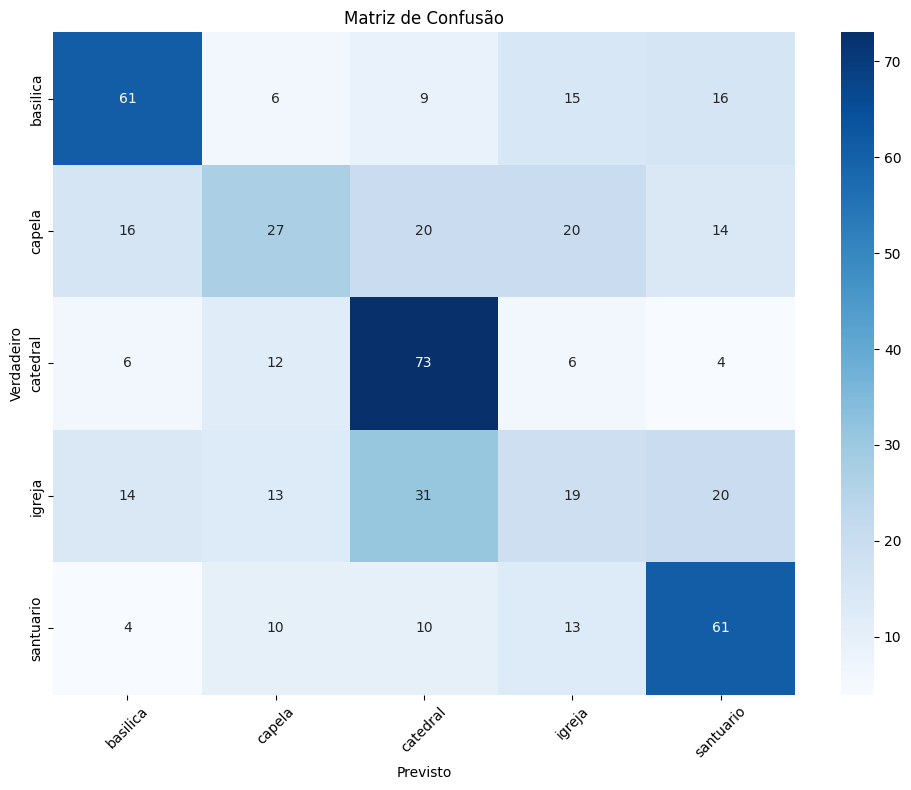

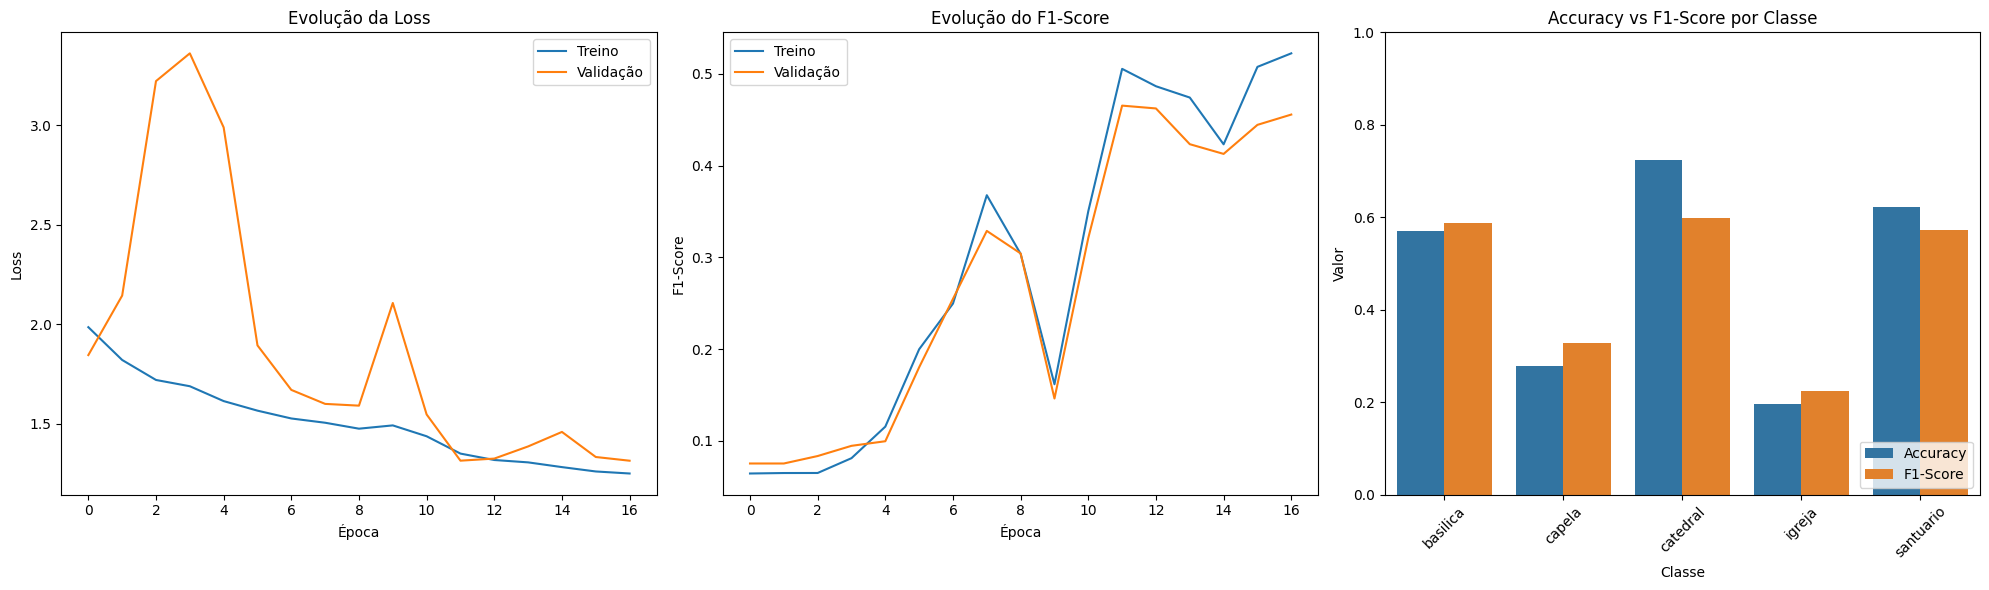

In [9]:
# =============================================
# 7. Avaliação e visualizações
# =============================================

# Preparar previsões
y_true, y_pred = [], []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(model1_dir / 'matriz_confusaoModel1.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcular métricas por classe
f1_per_class = f1_score(y_true, y_pred, average=None)

accuracy_per_class = []
for i in range(len(class_names)):
    idx = np.where(np.array(y_true) == i)
    acc = accuracy_score(np.array(y_true)[idx], np.array(y_pred)[idx])
    accuracy_per_class.append(acc)

# Gráficos de evolução e comparação
plt.figure(figsize=(20, 6))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# F1-Score treino vs validação
plt.subplot(1, 3, 2)
plt.plot(history.history['f1_score'], label='Treino')
plt.plot(history.history['val_f1_score'], label='Validação')
plt.title('Evolução do F1-Score')
plt.xlabel('Época')
plt.ylabel('F1-Score')
plt.legend()

# Preparar DataFrame para o gráfico comparativo Accuracy vs F1-Score por classe
df_metrics = pd.DataFrame({
    'Classe': class_names * 2,
    'Métrica': ['Accuracy'] * len(class_names) + ['F1-Score'] * len(class_names),
    'Valor': accuracy_per_class + list(f1_per_class)
})

plt.subplot(1, 3, 3)
sns.barplot(data=df_metrics, x='Classe', y='Valor', hue='Métrica')
plt.title('Accuracy vs F1-Score por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(model1_dir / 'evolucao_metricasModel1.png', dpi=300, bbox_inches='tight')
plt.show()